In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [4]:
path="/Users/kyradresen/Downloads/fat clever beach repo anyscale/Utility/0507_mtsamples_final.csv"
df = pd.read_csv(path)
print(df.shape)
df.head()

(2016, 26)


,Unnamed: 0,medical_specialty,transcription,age_related_sentence,extracted_text,word_count,med_masked_transcriptions,pii_masked_transcriptions,synthetic_sentence_nodp_temp0.6_topk50,synthetic_sentence_eps16_temp0.6_topk100,...,synthetic_sentence_nodp_temp1.0_topk100,synthetic_sentence_nodp_temp0.8_topk100,synthetic_sentence_nodp_temp0.6_topk100,synthetic_sentence_eps3_temp0.6_topk100,synthetic_sentence_eps3_temp0.8_topk100,synthetic_sentence_eps3_temp1.2_topk100,synthetic_sentence_eps3_temp1.2_topk50,synthetic_sentence_eps3_temp1_topk50,synthetic_sentence_eps3_temp0.8_topk50,synthetic_sentence_eps3_temp0.6_topk50
0,0,Neurology,"CC:, Confusion and slurred speech.,HX , (prima...","HX , (primarily obtained from boyfriend): This...",(primarily obtained from boyfriend): This 31 y...,43,(primarily obtained from boyfriend): This[AGE]...,(primarily obtained from boyfriend): This[AGE]...,The patient is a 55-year-old Caucasian female ...,The patient is a 38-year-old Caucasian male ag...,...,The patient presents to the patient has been s...,A 16-year-old female who was referred for our ...,The patient was brought to the operating room ...,HISTORY OF PRESENT ILLNESS: The patient is a 3...,"Pulmonary[SEP/H]After a consultation, the pati...",This is the history of multiple minor neurolog...,"According to the patient:The patient, an invas...",Orththroteonthroxy[SEPSEP][SEPES/H]The patient...,Gastroenterology[SEP.]The patient was a 22-yea...,The patient is a man who was treated to a card...
1,1,Cardiovascular/Pulmonary,"PREOPERATIVE DIAGNOSES,Airway obstruction seco...","INDICATIONS FOR SURGERY,The patient is a 50-ye...",The patient is a 50-year-old white male with h...,72,The patient is a[AGE] white[SEX] with history ...,The patient is a[AGE] white[SEX] with history ...,This is a 74-year-old boy who presented to the...,The patient was brought to the hospital with a...,...,The patient received a 13 cm x 4 cm diameter. ...,After informed consent was obtained was brough...,The patient was brought to the operating room ...,The patient is a 13-year-old female who has ha...,The patient who has suffered a serious neck pa...,This is an annual consultation with an adult-s...,.There is an ongoing patient history of bilate...,"Orthopedolosis,PESIAT, a health history for a ...","HISTORY OF PRESENT PRESENT:,The patient is a 2...",The patient is a 37-year-old who is a cardiac-...
2,2,Urology,"PROCEDURE: , Elective male sterilization via b...","PROCEDURE: , Elective male sterilization via b...",Elective male sterilization via bilateral vase...,43,Elective male sterilization via bilateral vase...,Elective male sterilization via bilateral vase...,"HISTORY OF PRESENT ILLNESS:, This is a 51-year...","Cardiovascular/Pulmonary[SEP:],HISTORY OF PRES...",...,The patient's room and brought to the operatin...,The patient was brought to the operating room ...,The patient is a 53-year-old white male with a...,The patient is a 91-year-old male with a histo...,The patient was done with a significant heart ...,The patient is well health at the operating ar...,"From this article, Dr. I have stated that her ...","PANIMA/PES/PROCES,P,This is a patient with the...",The patient is a 25-year-old male who is in a ...,The patient is a 39-year-old man who is diagno...
3,3,Urology,"DESCRIPTION:, The patient was placed in the s...","DESCRIPTION:, The patient was placed in the su...",The patient was placed in the supine position ...,44,The patient was placed in the supine position ...,The patient was placed in the supine position ...,The patient was brought to the operating room ...,The patient with a history of prostate cancer....,...,"The patient tolerated the procedure well.,2, a...",This is a 52-year-old male who fell to have a ...,The patient was brought in the operating room ...,The patient is a 2-year-old male who had under...,:PANOCFETERI: An patient is a 20-year-old woma...,This is a 26-year-old couple who lives for a 2...,The patient is 5. OF OF PRESESTES AND TREASIAT...,;

## Remove the concetenated Target Variable for the synthetic differentially private text

In [6]:
def remove_before_sep(df, start_col):
    """
    Removes everything before '[SEP]' in the specified columns of the DataFrame starting from a given column index.

    Parameters:
    - df: DataFrame containing the data.
    - start_col: The index of the column to start processing from.

    Returns:
    - df: DataFrame with the processed columns.
    """
    # Define the regular expression pattern to match everything before '[SEP]'
    pattern = re.compile(r'.*?\[SEP\]')

    # Apply the regular expression to each column starting from start_col
    for column_name in df.columns[start_col:]:
        df[column_name] = df[column_name].apply(lambda x: re.sub(pattern, '', str(x)))

    return df

In [7]:
df = remove_before_sep(df, 3)

### N-gram Analysis

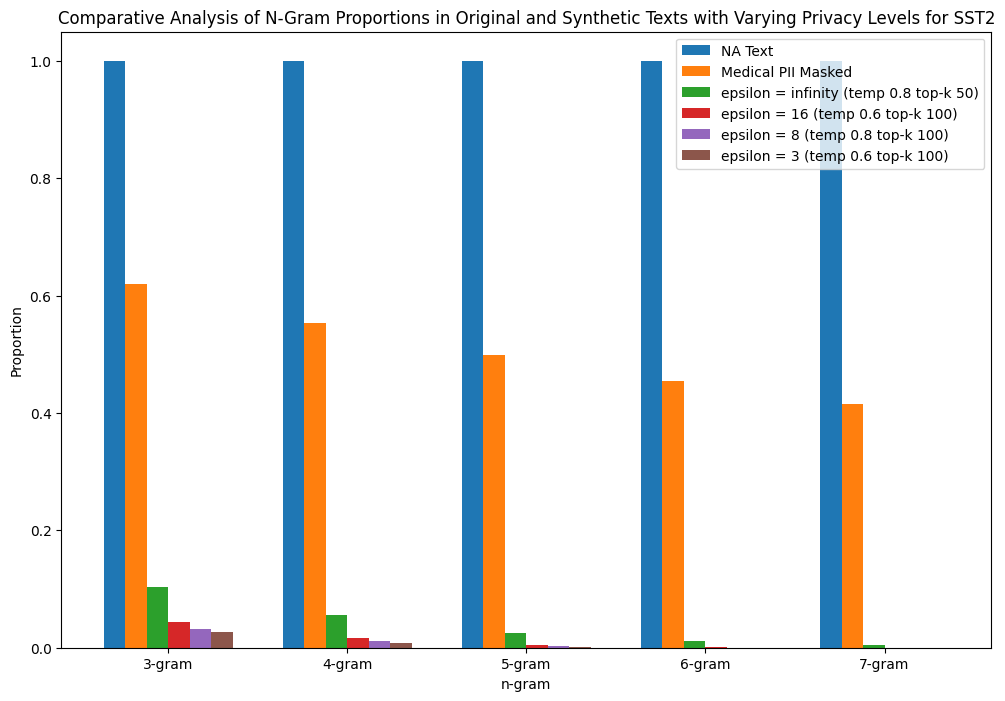

n-gram  extracted_text  med_masked_transcriptions  synthetic_sentence_nodp_temp0.8_topk50  synthetic_sentence_eps16_temp0.6_topk100  synthetic_sentence_eps8_temp0.8_topk100  synthetic_sentence_eps3_temp0.6_topk100
3-gram             1.0                   0.619542                                0.103158                                  0.044344                                 0.032247                                 0.026495
4-gram             1.0                   0.554243                                0.056240                                  0.015899                                 0.010760                                 0.008338
5-gram             1.0                   0.498568                                0.025934                                  0.004029                                 0.002253                                 0.001719
6-gram             1.0                   0.453846                                0.010940                                  0.000831             

In [9]:
def get_ngrams(text, n):
    if not text.strip():  # Check for empty or whitespace-only text
        return []
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(n, n), stop_words='english')
    try:
        ngrams = vectorizer.fit_transform([text])
        ngram_list = vectorizer.get_feature_names_out()
    except ValueError:
        ngram_list = []
    return ngram_list

def count_ngrams(texts, n):
    ngrams_counter = Counter()
    for text in texts:
        ngrams = get_ngrams(text, n)
        ngrams_counter.update(ngrams)
    return ngrams_counter

def calculate_ngram_proportions(df, original_col, synthetic_cols, ngram_range=(3, 7)):
    original_texts = df[original_col].tolist()

    results = {
        'n-gram': []
    }

    synthetic_proportions = {col: [] for col in synthetic_cols}

    for n in range(ngram_range[0], ngram_range[1] + 1):
        original_ngrams_counter = count_ngrams(original_texts, n)
        total_original_ngrams = sum(original_ngrams_counter.values())

        for col in synthetic_cols:
            synthetic_texts = df[col].tolist()
            synthetic_ngrams_counter = count_ngrams(synthetic_texts, n)
            total_synthetic_ngrams = sum(synthetic_ngrams_counter.values())

            if total_original_ngrams == 0:
                original_proportion = 0
            else:
                # Calculate the proportion of original n-grams that appear in the synthetic text
                overlap_ngrams = sum((original_ngrams_counter & synthetic_ngrams_counter).values())
                original_proportion = overlap_ngrams / total_original_ngrams

            synthetic_proportions[col].append(original_proportion)

        results['n-gram'].append(f'{n}-gram')

    for col in synthetic_cols:
        results[col] = synthetic_proportions[col]

    return pd.DataFrame(results)

def plot_ngram_proportions(df):
    fig, ax = plt.subplots(figsize=(12, 8))
    x = np.arange(len(df['n-gram']))
    width = 0.12

    labels = {
        'extracted_text': 'NA Text',
        'med_masked_transcriptions': 'Medical PII Masked',
        'synthetic_sentence_nodp_temp0.8_topk50': 'epsilon = infinity (temp 0.8 top-k 50)',
        'synthetic_sentence_eps16_temp0.6_topk100': 'epsilon = 16 (temp 0.6 top-k 100)',
        'synthetic_sentence_eps8_temp0.8_topk100': 'epsilon = 8 (temp 0.8 top-k 100)',
        'synthetic_sentence_eps3_temp0.6_topk100': 'epsilon = 3 (temp 0.6 top-k 100)'
    }

    for i, col in enumerate(df.columns[1:], start=1):
        ax.bar(x + (i-1) * width, df[col], width, label=labels[col])

    ax.set_xlabel('n-gram')
    ax.set_ylabel('Proportion')
    ax.set_title('Comparative Analysis of N-Gram Proportions in Original and Synthetic Texts with Varying Privacy Levels for SST2')
    ax.set_xticks(x + width * (len(df.columns) - 2) / 2)
    ax.set_xticklabels(df['n-gram'])
    ax.legend()

    plt.show()

def output_ngram_proportions(df):
    print(df.to_string(index=False))

synthetic_cols = [
    'extracted_text',
    'med_masked_transcriptions',
    'synthetic_sentence_nodp_temp0.8_topk50',
    'synthetic_sentence_eps16_temp0.6_topk100',
    'synthetic_sentence_eps8_temp0.8_topk100',
    'synthetic_sentence_eps3_temp0.6_topk100'
]

ngram_proportions_df = calculate_ngram_proportions(df, 'extracted_text', synthetic_cols)
plot_ngram_proportions(ngram_proportions_df)
output_ngram_proportions(ngram_proportions_df)
